# Essential Reynolds Comparison Analysis
Minimal code for HOSVD analysis and truncation method comparison

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.tenalg import multi_mode_dot
import kagglehub
from tqdm import tqdm
import global_variables

## Data Loading

In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
reynolds_numbers = [7000, 8000, 9000, 10000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]

# Get metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
Nx, Ny = metadata['global']['Nxyz']
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")
print(f"Reynolds: {reynolds_numbers}")

Grid: 1600x2000, Subsampled: 160x200
Reynolds: [7000, 8000, 9000, 10000]


In [3]:
# Load tensors
tensors = {}
for data_path, re_num in zip(data_paths, reynolds_numbers):
    key = f"Re{re_num}"
    print(f"Loading {key}...")
    
    with open(data_path + '/info.json') as f:
        metadata_re = json.load(f)
    
    tensor = np.zeros((Ny//subsample_y, Nx//subsample_x, n_species, n_snapshots))
    
    for t_idx in tqdm(range(n_snapshots)):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
            filename_key = file_key_map[comp_name]
            filename = metadata_re['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
    tensors[key] = tensor

Loading Re7000...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:25<00:00,  7.74it/s]


Loading Re8000...


100%|██████████| 200/200 [00:20<00:00,  9.58it/s]


Loading Re9000...


100%|██████████| 200/200 [00:24<00:00,  8.14it/s]


Loading Re10000...


100%|██████████| 200/200 [00:23<00:00,  8.50it/s]


## Scaling and Centering

In [4]:
# Apply log-scaling and standardization
tensors_scaled = {}
epsilon = 1e-12

for dataset_path, tensor in tensors.items():
    tensor_scaled = tensor.copy()
    for c_idx, comp_name in enumerate(component_names):
        component_data = tensor_scaled[:, :, c_idx, :].copy()
        component_data = np.log10(np.maximum(component_data, epsilon))
        mean_val = component_data.mean()
        std_val = component_data.std()
        component_data = (component_data - mean_val) / (std_val if std_val > epsilon else epsilon)
        tensor_scaled[:, :, c_idx, :] = component_data
    tensors_scaled[dataset_path] = tensor_scaled

## HOSVD Decomposition

In [5]:
decomposition_results = {}

for dataset_key, tensor in tensors_scaled.items():
    print(f"\nHOSVD for {dataset_key}...")
    
    U_y, _, _ = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
    U_x, _, _ = np.linalg.svd(tl.unfold(tensor, mode=1), full_matrices=False)
    U_chem, _, _ = np.linalg.svd(tl.unfold(tensor, mode=2), full_matrices=False)
    U_time, _, _ = np.linalg.svd(tl.unfold(tensor, mode=3), full_matrices=False)
    
    core = multi_mode_dot(tensor, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])
    
    decomposition_results[dataset_key] = {
        "core": core,
        "U_y": U_y,
        "U_x": U_x,
        "U_chem": U_chem,
        "U_time": U_time,
        "factors": [U_y, U_x, U_chem, U_time],
    }
    print(f"Core shape: {core.shape}, norm: {np.linalg.norm(core):.4f}")


HOSVD for Re7000...
Core shape: (200, 160, 8, 200), norm: 7155.4175

HOSVD for Re8000...
Core shape: (200, 160, 8, 200), norm: 7155.4175

HOSVD for Re9000...
Core shape: (200, 160, 8, 200), norm: 7155.4175

HOSVD for Re10000...
Core shape: (200, 160, 8, 200), norm: 7155.4175


## Truncation Method Comparison

In [ ]:
# Compare standard vs coupling-based truncation based on energy retention
energy_thresholds = [99.5, 99.6, 99.7, 99.8, 99.9]
comparison_results = {}

for re in reynolds_numbers:
    key = f"Re{re}"
    core = decomposition_results[key]['core']
    U_y = decomposition_results[key]['U_y']
    U_x = decomposition_results[key]['U_x']
    U_chem = decomposition_results[key]['U_chem']
    U_time = decomposition_results[key]['U_time']
    original = tensors_scaled[key]

    errors_standard = []
    errors_coupling = []
    ranks_used_standard = []
    ranks_used_coupling = []

    print(f"\n{key}: Comparing truncation methods")

    for energy_pct in energy_thresholds:
        energy_threshold = energy_pct / 100.0

        # Standard truncation: select modes based on energy in each dimension
        # Compute energy for each mode
        sv_y = np.array([np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])])
        sv_x = np.array([np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])])
        sv_chem = np.array([np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])])
        sv_time = np.array([np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])])

        energy_y = sv_y**2 / np.sum(sv_y**2)
        energy_x = sv_x**2 / np.sum(sv_x**2)
        energy_chem = sv_chem**2 / np.sum(sv_chem**2)
        energy_time = sv_time**2 / np.sum(sv_time**2)

        cum_energy_y = np.cumsum(energy_y)
        cum_energy_x = np.cumsum(energy_x)
        cum_energy_chem = np.cumsum(energy_chem)
        cum_energy_time = np.cumsum(energy_time)

        rank_y = np.searchsorted(cum_energy_y, energy_threshold) + 1
        rank_x = np.searchsorted(cum_energy_x, energy_threshold) + 1
        rank_chem = np.searchsorted(cum_energy_chem, energy_threshold) + 1
        rank_time = np.searchsorted(cum_energy_time, energy_threshold) + 1

        rank_y = min(rank_y, core.shape[0])
        rank_x = min(rank_x, core.shape[1])
        rank_chem = min(rank_chem, core.shape[2])
        rank_time = min(rank_time, core.shape[3])

        core_std = core[:rank_y, :rank_x, :rank_chem, :rank_time]
        reconst_std = multi_mode_dot(
            core_std,
            [U_y[:, :rank_y], U_x[:, :rank_x], U_chem[:, :rank_chem], U_time[:, :rank_time]],
            modes=[0, 1, 2, 3]
        )
        error_std = np.linalg.norm(original - reconst_std) / np.linalg.norm(original)
        errors_standard.append(error_std)
        ranks_used_standard.append((rank_y, rank_x, rank_chem, rank_time))

        # Coupling-based selection: select modes based on coupling energy
        coupling_chem_x = np.sum(np.abs(core), axis=(0, 3))
        coupling_chem_y = np.sum(np.abs(core), axis=(1, 3))
        coupling_chem_t = np.sum(np.abs(core), axis=(0, 1))

        selected_x = set()
        selected_y = set()
        selected_t = set()

        for chem_idx in range(core.shape[2]):
            # Select X modes based on energy threshold
            x_coupling = coupling_chem_x[:, chem_idx]
            x_energy = x_coupling**2
            x_sorted_idx = np.argsort(x_energy)[::-1]
            x_cum_energy = np.cumsum(x_energy[x_sorted_idx]) / np.sum(x_energy)
            x_n_modes = np.searchsorted(x_cum_energy, energy_threshold) + 1
            x_n_modes = min(x_n_modes, len(x_coupling))
            selected_x.update(x_sorted_idx[:x_n_modes])

            # Select Y modes based on energy threshold
            y_coupling = coupling_chem_y[:, chem_idx]
            y_energy = y_coupling**2
            y_sorted_idx = np.argsort(y_energy)[::-1]
            y_cum_energy = np.cumsum(y_energy[y_sorted_idx]) / np.sum(y_energy)
            y_n_modes = np.searchsorted(y_cum_energy, energy_threshold) + 1
            y_n_modes = min(y_n_modes, len(y_coupling))
            selected_y.update(y_sorted_idx[:y_n_modes])

            # Select Time modes based on energy threshold
            t_coupling = coupling_chem_t[chem_idx, :]
            t_energy = t_coupling**2
            t_sorted_idx = np.argsort(t_energy)[::-1]
            t_cum_energy = np.cumsum(t_energy[t_sorted_idx]) / np.sum(t_energy)
            t_n_modes = np.searchsorted(t_cum_energy, energy_threshold) + 1
            t_n_modes = min(t_n_modes, len(t_coupling))
            selected_t.update(t_sorted_idx[:t_n_modes])

        selected_x = sorted(list(selected_x))
        selected_y = sorted(list(selected_y))
        selected_t = sorted(list(selected_t))

        core_coup = core[np.ix_(selected_y, selected_x, range(core.shape[2]), selected_t)]
        reconst_coup = multi_mode_dot(
            core_coup,
            [U_y[:, selected_y], U_x[:, selected_x], U_chem, U_time[:, selected_t]],
            modes=[0, 1, 2, 3]
        )
        error_coup = np.linalg.norm(original - reconst_coup) / np.linalg.norm(original)
        errors_coupling.append(error_coup)
        ranks_used_coupling.append((len(selected_y), len(selected_x), core.shape[2], len(selected_t)))

        print(f"  {energy_pct}% energy - Standard: {rank_y}x{rank_x}x{rank_chem}x{rank_time}, " +
              f"Coupling: {len(selected_y)}x{len(selected_x)}x{core.shape[2]}x{len(selected_t)}")

    comparison_results[key] = {
        'energy_thresholds': energy_thresholds,
        'errors_standard': errors_standard,
        'errors_coupling': errors_coupling,
        'ranks_standard': ranks_used_standard,
        'ranks_coupling': ranks_used_coupling
    }

print("\nComparison complete")

## Final Visualization

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()
colors_re = plt.cm.viridis(np.linspace(0, 1, len(reynolds_numbers)))

# Standard truncation
ax = axes[0]
for idx, re in enumerate(reynolds_numbers):
    key = f"Re{re}"
    energies = comparison_results[key]['energy_thresholds']
    errors_standard = comparison_results[key]['errors_standard']
    ax.plot(energies, errors_standard, 'o-', color=colors_re[idx], 
            linewidth=2, markersize=6, label=f'Re={re}')
ax.set_xlabel('Energy Retained (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Standard Truncation', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Coupling-based
ax = axes[1]
for idx, re in enumerate(reynolds_numbers):
    key = f"Re{re}"
    energies = comparison_results[key]['energy_thresholds']
    errors_coupling = comparison_results[key]['errors_coupling']
    ax.plot(energies, errors_coupling, 's-', color=colors_re[idx], 
            linewidth=2, markersize=6, label=f'Re={re}')
ax.set_xlabel('Energy Retained (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Coupling-Based Selection', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Average comparison
ax = axes[2]
x_pos = np.arange(len(reynolds_numbers))
width = 0.35
avg_errors_standard = [np.mean(comparison_results[f"Re{re}"]['errors_standard']) 
                       for re in reynolds_numbers]
avg_errors_coupling = [np.mean(comparison_results[f"Re{re}"]['errors_coupling']) 
                       for re in reynolds_numbers]
ax.bar(x_pos - width/2, avg_errors_standard, width, 
       label='Standard', alpha=0.8, color='#E74C3C')
ax.bar(x_pos + width/2, avg_errors_coupling, width, 
       label='Coupling-Based', alpha=0.8, color='#3498DB')
ax.set_xlabel('Reynolds Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Average Error Across All Energy Thresholds', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'Re={re}' for re in reynolds_numbers])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Improvement
ax = axes[3]
for idx, re in enumerate(reynolds_numbers):
    key = f"Re{re}"
    energies = comparison_results[key]['energy_thresholds']
    errors_standard = np.array(comparison_results[key]['errors_standard'])
    errors_coupling = np.array(comparison_results[key]['errors_coupling'])
    improvement = ((errors_standard - errors_coupling) / errors_standard) * 100
    ax.plot(energies, improvement, 'D-', color=colors_re[idx], 
            linewidth=2, markersize=6, label=f'Re={re}')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Energy Retained (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Error Reduction: Coupling vs Standard (%)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

fig.suptitle('Truncation Method Comparison: Standard vs Coupling-Based Selection', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Si prega

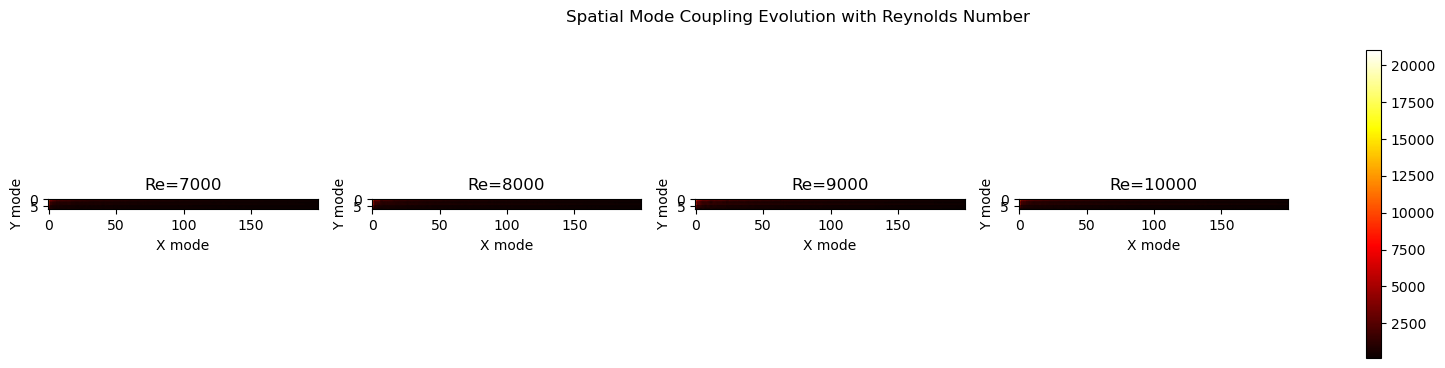

Coupling pattern correlation Re7000 vs Re8000: 0.982
Coupling pattern correlation Re8000 vs Re9000: 0.984
Coupling pattern correlation Re9000 vs Re10000: 0.982


In [8]:
# Calculate coupling matrices for each Re
coupling_matrices = {}
for re in reynolds_numbers:
    key = f"Re{re}"
    core = decomposition_results[key]['core']
    
    # Spatial coupling matrix (Y-X interaction)
    coupling_YX = np.zeros((core.shape[2], core.shape[3]))
    for i in range(core.shape[2]):
        for j in range(core.shape[3]):
            coupling_YX[i, j] = np.sum(np.abs(core[:, :, i, j]))
    
    coupling_matrices[key] = coupling_YX

# Compare coupling patterns across Re
fig, axes = plt.subplots(1, len(reynolds_numbers), figsize=(20, 4))
for idx, re in enumerate(reynolds_numbers):
    im = axes[idx].imshow(coupling_matrices[f"Re{re}"], cmap='hot')
    axes[idx].set_title(f'Re={re}')
    axes[idx].set_xlabel('X mode')
    axes[idx].set_ylabel('Y mode')
plt.colorbar(im, ax=axes)
plt.suptitle('Spatial Mode Coupling Evolution with Reynolds Number')
plt.show()

# Quantify coupling similarity
from scipy.stats import spearmanr
for i, re1 in enumerate(reynolds_numbers[:-1]):
    re2 = reynolds_numbers[i+1]
    corr, pval = spearmanr(
        coupling_matrices[f"Re{re1}"].flatten(),
        coupling_matrices[f"Re{re2}"].flatten()
    )
    print(f"Coupling pattern correlation Re{re1} vs Re{re2}: {corr:.3f}")

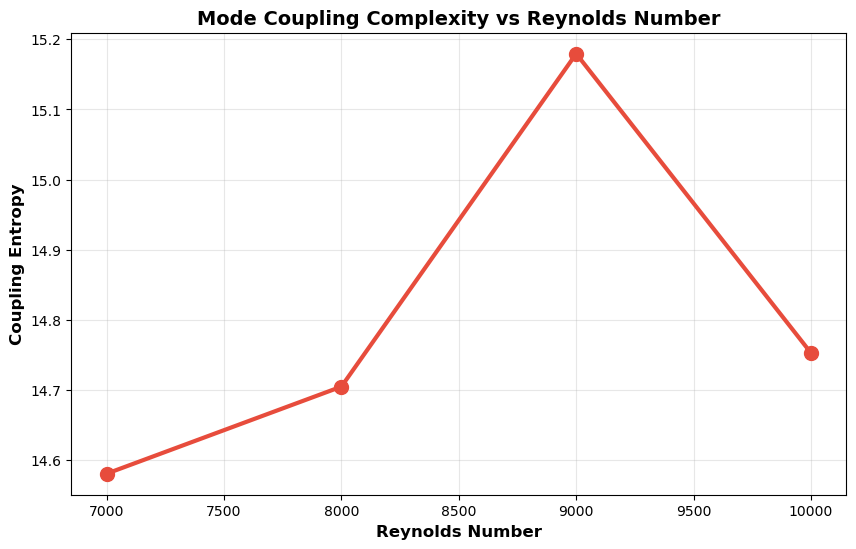

In [9]:
# Calculate coupling entropy for each Re
coupling_entropy = {}
for re in reynolds_numbers:
    key = f"Re{re}"
    core = decomposition_results[key]['core']
    
    # Normalize core to probability distribution
    core_abs = np.abs(core)
    core_prob = core_abs / np.sum(core_abs)
    
    # Shannon entropy
    entropy = -np.sum(core_prob * np.log(core_prob + 1e-10))
    coupling_entropy[re] = entropy

# Plot entropy vs Re
fig, ax = plt.subplots(figsize=(10, 6))
res = list(coupling_entropy.keys())
entropies = list(coupling_entropy.values())
ax.plot(res, entropies, 'o-', linewidth=3, markersize=10, color='#E74C3C')
ax.set_xlabel('Reynolds Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Coupling Entropy', fontsize=12, fontweight='bold')
ax.set_title('Mode Coupling Complexity vs Reynolds Number', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.show()